# Import Library dan Package

In [1]:
# ---------------------------------------
# Manipulasi data & utilitas umum
# ---------------------------------------
import pandas as pd
import numpy as np

# ---------------------------------------
# Visualisasi
# ---------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------
# Text processing untuk CBF
# ---------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------------------
# Pra-pemrosesan & evaluasi
# ---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------------------
# Deep learning untuk CF
# ---------------------------------------
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# ---------------------------------------
# Sistem & konfigurasi
# ---------------------------------------
import os
import random

# ---------------------------------------
# Konfigurasi visualisasi dan runtime
# ---------------------------------------
pd.set_option('display.max_columns', None)

# Load Dataset

In [2]:
# Load dataset
movies_df = pd.read_csv('../data/movies.csv')
ratings_df = pd.read_csv('../data/ratings.csv')

In [3]:
# Tampilkan 5 baris pertama dari dataset movies
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# Tampilkan 5 baris pertama dari dataset ratings
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


# Data Understanding & EDA

In [5]:
# Tampilkan informasi umum tentang dataset movies
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB


In [6]:
# Tampilkan informasi umum tentang dataset movies
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


In [7]:
# menampilkan jumlah null values di setiap kolom 
print(movies_df.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


In [8]:
# menampilkan jumlah null values di setiap kolom
print(ratings_df.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [9]:
# Statistik deskriptif untuk ratings
ratings_df.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


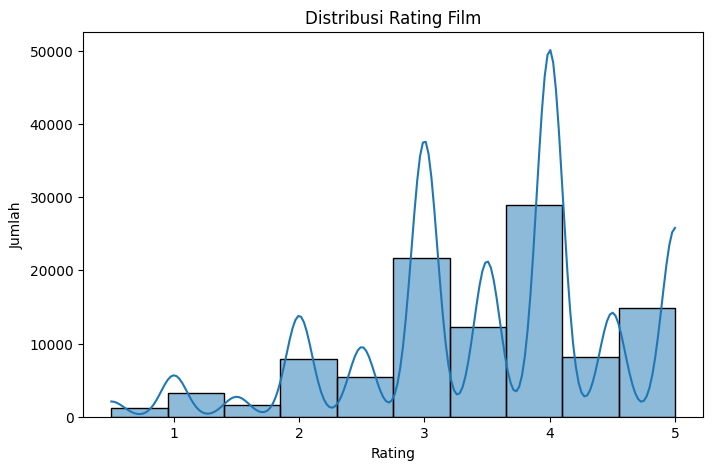

In [10]:
# Plot distribusi rating
plt.figure(figsize=(8,5))
sns.histplot(ratings_df['rating'], bins=10, kde=True)
plt.title("Distribusi Rating Film")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()


Jumlah film unik: 10329


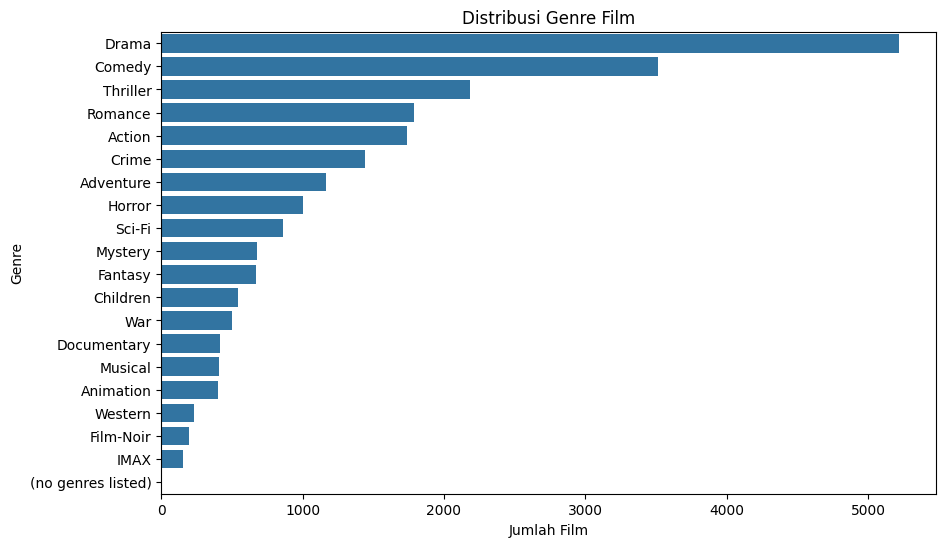

In [11]:
# Jumlah film unik
print("Jumlah film unik:", movies_df['movieId'].nunique())

# Pisahkan genre
movies_df['genre_list'] = movies_df['genres'].apply(lambda x: x.split('|') if isinstance(x, str) else [])

# Hitung genre terbanyak
from collections import Counter
genre_counter = Counter([genre for genres in movies_df['genre_list'] for genre in genres])

# Tampilkan genre populer
genre_df = pd.DataFrame(genre_counter.items(), columns=['Genre', 'Jumlah']).sort_values(by='Jumlah', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=genre_df, x='Jumlah', y='Genre')
plt.title("Distribusi Genre Film")
plt.xlabel("Jumlah Film")
plt.ylabel("Genre")
plt.show()


Struktur Dataset
movies.csv memiliki 10.329 entri dan terdiri dari 3 kolom: movieId, title, dan genres.

ratings.csv memiliki 105.339 entri dengan 4 kolom: userId, movieId, rating, dan timestamp.

2. Statistik Deskriptif dari ratings.csv
Rentang rating: dari 0.5 hingga 5.0.

Rata-rata rating: sekitar 3.52, menunjukkan kecenderungan pengguna memberikan penilaian positif terhadap film.

Mayoritas rating berada di antara 3.0 hingga 4.0, mencerminkan bahwa pengguna cenderung tidak memberikan penilaian ekstrem (terlalu rendah atau terlalu tinggi).

3. Distribusi Rating Film
📈 (Gambar Histogram + KDE)

Insight:

Rating 4.0 adalah yang paling umum diberikan.

Jumlah rating menurun signifikan untuk nilai rendah seperti 0.5–2.0, yang menunjukkan pengguna jarang memberikan rating negatif.

Kurva KDE menunjukkan distribusi yang miring ke kiri, menandakan kecenderungan optimistik dalam penilaian.

4. Distribusi Genre Film
Insight:

Drama adalah genre yang paling banyak muncul, diikuti oleh Comedy, Thriller, dan Romance.

Genre seperti IMAX, Film-Noir, dan Western memiliki jumlah film yang relatif sedikit.

Keberagaman genre ini menjadi potensi penting untuk Content-Based Filtering, karena bisa dimanfaatkan untuk menghitung kemiripan antar film berdasarkan genre.

5. Kondisi Data

Missing Values:
Berdasarkan hasil .isnull().sum() pada kedua dataset, tidak ditemukan missing values pada kolom manapun. Hal ini memastikan seluruh data dapat langsung digunakan tanpa perlu proses imputasi atau penghapusan baris/kolom.

Duplikasi:
Tidak ditemukan data duplikat pada kedua dataset setelah dilakukan pengecekan. Setiap baris pada movies.csv dan ratings.csv merepresentasikan entitas unik.

Outlier:
Pada data rating, tidak ditemukan outlier yang mencolok karena seluruh nilai rating berada pada rentang yang valid (0.5 hingga 5.0) sesuai standar MovieLens.



# Data Preparation

In [12]:
# Vectorizer untuk genres
vectorizer = CountVectorizer(token_pattern=r'[^|]+')
genre_matrix = vectorizer.fit_transform(movies_df['genres'])

# Matriks kemiripan antar film
cosine_sim = cosine_similarity(genre_matrix)

# Mapping judul ke indeks (hanya didefinisikan di sini)
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()

In [13]:
# menghapus kolom timestamp dari ratings_df
ratings = ratings_df.drop('timestamp', axis=1)
ratings.head()

,userId,movieId,rating
0,1,16,4.0
1,1,24,1.5
2,1,32,4.0
3,1,47,4.0
4,1,50,4.0


In [14]:
from sklearn.preprocessing import LabelEncoder

# Menggunakan LabelEncoder untuk mengubah userId dan movieId menjadi numerik
user_enc = LabelEncoder()
movie_enc = LabelEncoder()

# Mengubah userId dan movieId menjadi numerik
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'].values)

# Menghapus kolom userId dan movieId yang asli
num_users = ratings['user'].nunique()
num_movies = ratings['movie'].nunique()

# print("Jumlah unik userId:", ratings['userId'].nunique())
print("Jumlah unik user:", num_users)
print("Jumlah unik movie:", num_movies)

Jumlah unik user: 668
Jumlah unik movie: 10325


In [15]:
# memisahkan fitur dan target
X = ratings[['user', 'movie']].values
y = ratings['rating'].values

# Content-Based Filtering

## Modeling

Langkah-langkah:
1. Ekstraksi Fitur: Gunakan genres dari dataset movies.csv.

2. Representasi Fitur: Transformasi dengan CountVectorizer().

3. Perhitungan Similarity: Menggunakan cosine similarity antar film.

4. Fungsi Rekomendasi: Berdasarkan film yang dipilih, cari film paling mirip.

In [16]:
# Vectorizer untuk genres
vectorizer = CountVectorizer(token_pattern=r'[^|]+')
genre_matrix = vectorizer.fit_transform(movies_df['genres'])

# Matriks kemiripan antar film
cosine_sim = cosine_similarity(genre_matrix)

# Mapping judul ke indeks
indices = pd.Series(movies_df.index, index=movies_df['title']).drop_duplicates()


In [17]:
# Fungsi rekomendasi
def recommend_movies_cbf(title, num_recommendations=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies_df.iloc[movie_indices][['title', 'genres']]

## Evaluasi

In [18]:
recommend_movies_cbf('Toy Story (1995)', 10)

,title,genres
1815,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
2496,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2967,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3166,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
3811,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6617,DuckTales: The Movie - Treasure of the Lost La...,Adventure|Animation|Children|Comedy|Fantasy
6997,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
7382,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
7987,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy
9215,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy


Evaluasi CBF (Kualitatif)
- Evaluasi pada sistem CBF bersifat kualitatif → apakah hasil rekomendasi memang relevan berdasarkan genre film.

- Misal dalam contoh disini memilih film 'Toy Story (1995)', maka rekomendasi yang muncul cenderung film dengan genre Animation | Children | Comedy.

In [19]:
# Precision@K untuk evaluasi CBF
def precision_at_k(recommended_titles, reference_title, k=5):
    # Ambil genre referensi
    ref_genres = set(movies_df[movies_df['title'] == reference_title]['genres'].iloc[0].split('|'))
    relevant = 0
    for title in recommended_titles[:k]:
        rec_genres = set(movies_df[movies_df['title'] == title]['genres'].iloc[0].split('|'))
        if len(ref_genres & rec_genres) > 0:
            relevant += 1
    return relevant / k

# Contoh penggunaan Precision@K
cbf_result = recommend_movies_cbf('Toy Story (1995)', 10)
recommended_titles = cbf_result['title'].tolist()
precision5 = precision_at_k(recommended_titles, 'Toy Story (1995)', k=5)
print(f"Precision@5: {precision5:.2f}")

Precision@5: 1.00


Evaluasi CBF (Kuantitatif)

- **Precision@K** digunakan untuk mengukur proporsi rekomendasi teratas yang relevan dengan film referensi berdasarkan genre.
- Rumus:  

  Precision@K = (jumlah rekomendasi relevan dalam top-K) ÷ K
  
- hasil Precision@5 = 1.00, artinya 100% dari 5 rekomendasi teratas memiliki genre yang sama dengan film referensi.

In [20]:
# Recall@K untuk evaluasi CBF
def recall_at_k(recommended_titles, reference_title, k=5):
    # Ambil genre referensi
    ref_genres = set(movies_df[movies_df['title'] == reference_title]['genres'].iloc[0].split('|'))
    # Hitung jumlah genre unik pada film referensi (sebagai "jumlah relevan sebenarnya")
    total_relevant = len(ref_genres)
    # Hitung genre yang berhasil ter-rekomendasi di top-K
    found_genres = set()
    for title in recommended_titles[:k]:
        rec_genres = set(movies_df[movies_df['title'] == title]['genres'].iloc[0].split('|'))
        found_genres.update(ref_genres & rec_genres)
    return len(found_genres) / total_relevant if total_relevant > 0 else 0

# Contoh penggunaan Recall@K
recall5 = recall_at_k(recommended_titles, 'Toy Story (1995)', k=5)
print(f"Recall@5: {recall5:.2f}")

Recall@5: 1.00


Evaluasi CBF (Kuantitatif)

- **Recall@K** digunakan untuk mengukur seberapa banyak genre dari film referensi yang berhasil terwakili dalam rekomendasi top-K.
- Rumus:  

  Recall@K = (jumlah genre film referensi yang ada di top-K) ÷ (jumlah genre film referensi)

- Hasil Recall@5 = 1.00, artinya seluruh genre dari film referensi berhasil muncul pada 5 rekomendasi teratas.

# Collaborative Filtering (CF) dengan RecommenderNet

## Modeling

Langkah-langkah:
1. Split data: train dan test.

2. Bangun model RecommenderNet → arsitektur embedding untuk representasi vektor laten pengguna & film.

3. Latih model dengan Adam optimizer + fungsi loss MSE.

4. Evaluasi dengan Root Mean Squared Error (RMSE).

5. Buat fungsi rekomendasi khusus user.

In [21]:
# Train-test split
x = ratings[['user', 'movie']].values
y = ratings['rating'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [22]:
# Model RecommenderNet
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))
user_embedding = Embedding(num_users, 50)(user_input)
movie_embedding = Embedding(num_movies, 50)(movie_input)
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)
dot = Dot(axes=1)([user_vec, movie_vec])
output = Dense(1, activation='linear')(dot)
model = Model([user_input, movie_input], output)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

In [23]:
# Training
history = model.fit([x_train[:,0], x_train[:,1]], y_train,
                    validation_data=([x_test[:,0], x_test[:,1]], y_test),
                    epochs=10, batch_size=64)

Epoch 1/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 10.5108 - val_loss: 1.5627
Epoch 2/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 1.1540 - val_loss: 1.0109
Epoch 3/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.6864 - val_loss: 0.9453
Epoch 4/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 0.5142 - val_loss: 0.9479
Epoch 5/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.3896 - val_loss: 0.9537
Epoch 6/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 0.2911 - val_loss: 0.9896
Epoch 7/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.2224 - val_loss: 1.0013
Epoch 8/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.1725 - val_loss: 1.0234
Epoch 9/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - loss: 0.1372 - val_loss: 1.0307
Epoch 10/10
1317/1317 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - loss: 0.1129 - val_loss: 1.0407


## Evaluasi

In [24]:
# Evaluasi RMSE
y_pred = model.predict([x_test[:,0], x_test[:,1]]).flatten()
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")

659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE: 1.0202


### Fungsi Rekomendasi Personalized untuk User

In [25]:
def recommend_movies_cf(user_id, num_recommendations=10):
    encoded_user_id = user_enc.transform([user_id])[0]
    movie_ids = np.arange(num_movies)
    user_array = np.full(shape=num_movies, fill_value=encoded_user_id)
    predictions = model.predict([user_array, movie_ids]).flatten()
    top_indices = predictions.argsort()[-num_recommendations:][::-1]
    recommended_movie_ids = movie_enc.inverse_transform(top_indices)
    return movies_df[movies_df['movieId'].isin(recommended_movie_ids)][['movieId', 'title', 'genres']]

# Contoh penggunaan
recommend_movies_cf(user_id=100, num_recommendations=10)

323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,movieId,title,genres
170,198,Strange Days (1995),Action|Crime|Drama|Mystery|Sci-Fi|Thriller
231,261,Little Women (1994),Drama
263,300,Quiz Show (1994),Drama
389,441,Dazed and Confused (1993),Comedy
842,1035,"Sound of Music, The (1965)",Musical|Romance
1525,1959,Out of Africa (1985),Drama|Romance
1673,2114,"Outsiders, The (1983)",Drama
2197,2746,Little Shop of Horrors (1986),Comedy|Horror|Musical
4486,5991,Chicago (2002),Comedy|Crime|Drama|Musical
7762,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy


Evaluasi Collaborative Filtering

    Root Mean Squared Error (RMSE): 1.0202

✅ Interpretasi:
1. RMSE mengukur seberapa jauh rata-rata prediksi model terhadap nilai rating sebenarnya.
2. Semakin rendah RMSE → semakin baik prediksi model.
3. RMSE ≈ 1.0202 tergolong cukup baik, mengingat skala rating adalah 0.5 - 5.0.
Artinya, rata-rata kesalahan prediksi sekitar ±1 rating point, masih tergolong wajar dalam skenario sistem rekomendasi film.